In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import log
from interpolation import interp
from numba import njit, prange, cfunc
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# calibration
α=1
A=1.5
σ1=0.3
σ2=0.3
γ=0.95
μ=0.5
π=1.
β=0.9
ν=2
δ_range=np.array([0.93, 1.])
Pδ=np.array([0.5, 0.5])
ζ_range=np.array([1., 1.5])
Pζ=np.array([[0.5, 0.5], [0.5, 0.5]])

ω_min=1e-3
ω_max=100
n_ω=100

b_min=0.
b_max=0.
n_b=100

c_min=1e-3
c_max=10.
c_int=5.
n_c=100

n_ι=2

In [4]:
para = [α, A, σ1, σ2, γ, μ, π, β, ν, δ_range, Pδ, ζ_range, Pζ]
grids_para = [ω_min, ω_max, n_ω, b_min, b_max, n_b, c_min, c_max, n_c, n_ι]

In [5]:
# initial X
R=1.03

K=5
L=1
M=0.5

In [6]:
# R, K, L, M are arguments, not parameters
def function_factory(para, grids_para):
    
    α, A, σ1, σ2, γ, μ, π, β, ν, δ_range, Pδ, ζ_range, Pζ = para
    n_ζ = len(ζ_range)
    n_δ = len(δ_range)
    
    ω_min, ω_max, n_ω, b_min, b_max, n_b, c_min, c_max, n_c, n_ι = grids_para
    
    ω_range = np.linspace(ω_min, ω_max, n_ω)
    b_range = np.linspace(b_min, b_max, n_b)
    c_range = np.empty(n_c)
    c_range[:n_c//2] = np.linspace(c_min, c_int, n_c//2)
    c_range[n_c//2:] = np.linspace(c_int+(c_int-c_min)*2/n_c, c_max, n_c//2)
    ι_range = np.array([0, 1], int)

    # rental, wage, and price of intermediate goods
    def F_derivatives(K, L, M):
        """
        F(k, l, m) = A * k^σ1 * l^σ2 * m^(1-σ1-σ2)
        
        F_k (r) = σ1 * A * k^(σ1-1) * l^σ2 * m^(1-σ1-σ2)
        F_l (w) = σ2 * A * k^σ1 * l^(σ2-1) * m^(1-σ1-σ2)
        F_m (pM) = (1-σ1-σ2) * A * k^σ1 * l^σ2 * m^(-σ1-σ2)
        """
        # the common part
        Fklm = A * K**(σ1-1) * L**(σ2-1) * M**(-σ1-σ2)
        
        r = σ1 * Fklm * L * M
        w = σ2 * Fklm * K * M
        pM = (1-σ1-σ2) * Fklm * K * L
        
        return r, w, pM
    
    @njit(parallel=True)
    def utility(c):
        """
        CRRA utility.
        """
        
        utils = c ** (1-ν) / (1-ν)
        
        return utils
    
    def invention_value(R, pM):
        """
        The present value of a brand new intermediate goods invention.
        """
        
        j_bar = int(log((R / pM), γ))
        
        Γ = 0
        for j in range(j_bar+1):
            Γ += (γ**j * pM / R - 1) * R ** (-j)
            
        return Γ
    
    def initialize():
        
        # the first dimension is for bold or not
        # second is for work or not
        VWI = np.zeros((2, 2, n_ω, n_ζ, n_ι))
        # the last dimension is for optimal (c, k_next, b_next)
        DWI = np.zeros((2, 2, n_ω, n_ζ, n_ι, 3))
        D_bar = np.empty((2, n_ω, n_ζ))
        
        # ex ante value function
        V = np.zeros((2, n_ω, n_ζ))
        
        # optimal value function conditional on having invention opportunity
        Vbar = np.zeros((2, n_ω, n_ζ, 2))
        
        return VWI, DWI, D_bar, V, Vbar
    
    def solve_model(tol=1e-5, verbose=True):
        
        r, w, pM = F_derivatives(K, L, M)
        Γ_star = invention_value(R, pM)
        VWI, DWI, D_bar, V, Vbar = initialize()
        
        dist = np.inf
        i = 0
        while dist > tol:
            Vold = np.copy(V)
            for WI in prange(2):
                update_VWI(0, VWI, V, DWI, w, r, R, Γ_star)
                update_VWI(1, VWI, V, DWI, w, r, R, Γ_star)
            
            # optimization over decision of working of inventing
            D_bar[:, :, :] = VWI[:, 0, :, :, 1] < VWI[:, 1, :, :, 1]
            Vbar[:, :, :, 1] = np.max(VWI[:, :, :, :, 1], 1)
            Vbar[:, :, :, 0] = VWI[:, 0, :, :, 0]
            # ex ante value funtion
            # before the invention shock
            V = μ * Vbar[:, :, :, 1] + (1 - μ) * VWI[:, 0, :, :, 0]
            
            dist = np.max(np.abs(V-Vold))
            
            i += 1
            if i > 500:
                break
            
            if verbose:
                print(i, dist)
                
        return V, Vbar, DWI, D_bar
    
    @njit(parallel=False)
    def update_VWI(WI, VWI, V, DWI, w, r, R, Γ_star):
        """
        update VW if WI == 0
        update VI if WI == 1
        """
        for idx_ω in prange(n_ω):
            ω = ω_range[idx_ω]
            for idx_ζ in prange(n_ζ):
                ζ = ζ_range[idx_ζ]
                cashonhand = ζ * w + ω if WI == 0 else ω
                for ι in prange(n_ι):
                    # agent type: bold or cautious
                    for bold in range(2):
                        
                        # optimization over ct, kt+1, bt+1
                        val, c, k_next, b_next = opt_VWI(WI, V, w, r, R, Γ_star, bold, cashonhand, idx_ζ)
                        VWI[bold, WI, idx_ω, idx_ζ, ι] = val
                        DWI[bold, WI, idx_ω, idx_ζ, ι, :] = c, k_next, b_next
    
    @njit(parallel=False)
    def opt_VWI(WI, V, w, r, R, Γ_star, bold, cashonhand, idx_ζ):
        """
        optimization for worker if WI == 0
        optimization for inventor if WI == 1
        """
        val_opt = -np.inf
        c_opt = c_range[0]
        b_next_opt = b_range[0]
        k_next_opt = cashonhand - c_opt - b_next_opt

        # search for optimal consumption
        for idx_c in prange(n_c):
            c = c_range[idx_c]
            # utility of consumption
            utils = utility(c)
            # search for optimal borrowing
            for idx_b in prange(n_b):
                b_next = b_range[idx_b]
                k_next = cashonhand - c - b_next
                if k_next < 0.:
                    break
                val = utils
                for idx_δ_next in prange(n_δ):
                    δ_next = δ_range[idx_δ_next]
                    ω_next = (1+r) * δ_next * k_next + R * b_next
                    if WI == 0:
                        for idx_ζ_next in prange(n_ζ):
                            val += Pδ[idx_δ_next] * β * Pζ[idx_ζ, idx_ζ_next] * interp(ω_range, V[bold, :, idx_ζ_next], ω_next)
                    elif WI == 1:
                        for idx_ζ_next in prange(n_ζ):
                            val += Pδ[idx_δ_next] * β * π * Pζ[idx_ζ, idx_ζ_next] * interp(ω_range, V[bold, :, idx_ζ_next], ω_next+Γ_star)
                            val += Pδ[idx_δ_next] * β * (1-π) * Pζ[idx_ζ, idx_ζ_next] * interp(ω_range, V[bold, :, idx_ζ_next], ω_next)
                
                if val > val_opt:
                    val_opt = val
                    c_opt = c
                    k_next_opt = k_next
                    b_next_opt = b_next
                    
        return val_opt, c_opt, k_next_opt, b_next_opt                            

    return solve_model, F_derivatives, invention_value, initialize, update_VWI, utility

In [7]:
solve_model, F_derivatives, invention_value, initialize, update_VWI, utility = function_factory(para, grids_para)

In [8]:
# rental, wage, and price of intermediate goods
r, w, pM = F_derivatives(K, L, M)
print(r, w, pM)

0.11054052235042112 0.5527026117521057 1.4738736313389484


In [9]:
# effective vintage of intermediate good technology
j_bar = int(log((R / pM), γ))
j_bar

6

In [10]:
# The present value of a brand new intermediate goods invention
Γ_star = invention_value(R, pM)
Γ_star

1.5451874192467956

In [11]:
V, Vbar, DWI, D_bar = solve_model(verbose=False)

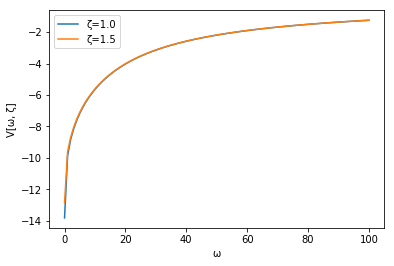

In [12]:
# value function given wealth and labor productivity
ω_range = np.linspace(ω_min, ω_max, n_ω)

for i in range(len(ζ_range)):
    plt.plot(ω_range, V[0, :, i], label=f"ζ={ζ_range[i]}")

plt.xlabel("ω")
plt.ylabel("V[ω, ζ]")
plt.legend()

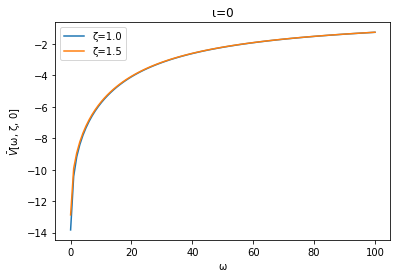

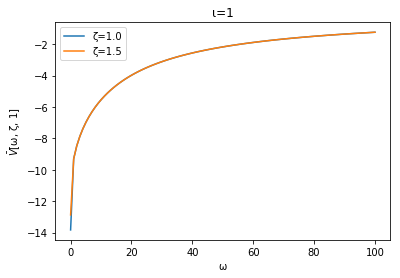

In [13]:
# value function given wealth, labor productivity, and invention chance
for ι in range(2):
    for i in range(len(ζ_range)):
        plt.plot(ω_range, Vbar[0, :, i, ι], label=f"ζ={ζ_range[i]}")
    
    plt.xlabel("ω")
    plt.ylabel(r"$\bar{V}$[ω, ζ, " + f"{ι}]")
    plt.title(f"ι={ι}")
    plt.legend()
    plt.show()

# Aggregates Calculation

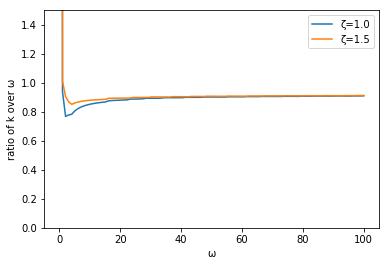

In [14]:
# k decision
ω_range = np.linspace(ω_min, ω_max, n_ω)

for i in range(len(ζ_range)):
    plt.plot(ω_range, DWI[0, 0, :, i, 0, 1] / ω_range, label=f"ζ={ζ_range[i]}")

plt.ylim([0., 1.5])
plt.xlabel("ω")
plt.ylabel("ratio of k over ω")
plt.legend()

##### for bold agents

In [15]:
from scipy.stats import gaussian_kde
import scipy.integrate as integrate

In [16]:
@njit(parallel=True)
def MC(popu, DWI, D_bar, seed=1234, maxiter=1000, tol=1e-5, verbose=True):
    """
    Monte Carlo simulation.
    """
    
    N = popu.shape[0] // 2
    
    np.random.seed(seed)
    
    ι_draw_rvs = np.random.random((maxiter, 2*N))
    δ_draw_rvs = np.random.random((maxiter, 2*N))
    π_draw_rvs = np.random.random((maxiter, 2*N))
    ζ_draw_rvs = np.random.random((maxiter, 2*N))
    
    for i in range(maxiter):
        popu_old = np.copy(popu)
        for j in prange(2*N):
            ι = 0 if ι_draw_rvs[i, j] < 0.5 else 1

            # update ω
            ω = popu[j, 0]
            idx_ζ = int(popu[j, 1])
            ζ = ζ_range[idx_ζ]

            if (ι == 1):
                p_invest = interp(ω_range, D_bar[0, :, idx_ζ], ω)

            if (ι == 0) or (p_invest < 0.5):
                # bound k by ω_max
                # otherwise it will explode because interp is using linear extrapolation
                k = min(interp(ω_range, DWI[0, 0, :, idx_ζ, ι, 1], ω), ω_max)
                b = interp(ω_range, DWI[0, 0, :, idx_ζ, ι, 2], ω)
            else:
                k = min(interp(ω_range, DWI[0, 1, :, idx_ζ, ι, 1], ω), ω_max)
                b = interp(ω_range, DWI[0, 1, :, idx_ζ, ι, 2], ω)

            idx_δ = 0 if δ_draw_rvs[i, j] < Pδ[0] else 1
            δ = δ_range[idx_δ]

            ωnext = (1 + r) * δ * k + R * b

            if π_draw_rvs[i, j] < π:
                ωnext += Γ_star

            popu[j, 0] = ωnext

            # update ζ
            if ζ_draw_rvs[i, j] > Pζ[idx_ζ, idx_ζ]:
                popu[j, 1] = 1 - idx_ζ

In [17]:
# draw initial (ω, ζ) distribution
# e.g. uniform distribution
N = 10000

popu = np.empty((2*N, 2))
popu[:N, 0] = np.linspace(ω_min, ω_max, N)
popu[:N, 1] = 0
popu[N:, 0] = np.linspace(ω_min, ω_max, N)
popu[N:, 1] = 1

In [18]:
MC(popu, DWI, D_bar)

In [19]:
pdf1 = gaussian_kde(popu[popu[:, 1] == 0, 0])
pdf2 = gaussian_kde(popu[popu[:, 1] == 1, 0])

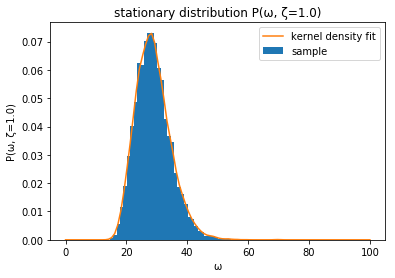

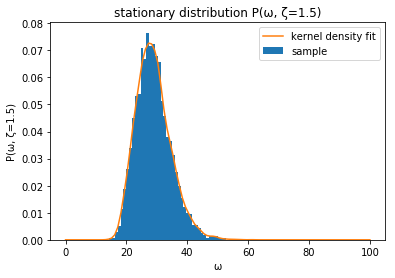

In [20]:
for i in range(2):
    pdf = [pdf1, pdf2][i]
    plt.hist(popu[popu[:, 1] == i, 0], bins=50, density=True, label="sample")
    plt.plot(np.linspace(0., 100., 100), pdf(np.linspace(0., 100., 100)), label="kernel density fit")
    plt.title(f"stationary distribution P(ω, ζ={ζ_range[i]})")
    plt.xlabel("ω")
    plt.ylabel(f"P(ω, ζ={ζ_range[i]})")
    plt.legend()
    plt.show()

#### Integration

In [21]:
DK = DWI[:, :, :, :, :, 1]
DB = DWI[:, :, :, :, :, 0]

In [22]:
# worker
def fW(ω, pdf, idx_ζ, DA):
    """
    A = K, B
    """
    A = interp(ω_range, DA[0, 0, :, idx_ζ, 0], ω)
    density = pdf(ω)
    return density * A

In [23]:
# KW0
integrate.quad(fW, ω_min, ω_max, args=(pdf1, 0, DK), limit=100)

/Users/zejinshi/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


(25.70050364904711, 5.186152365989462e-06)

In [24]:
# KW1
integrate.quad(fW, ω_min, ω_max, args=(pdf1, 1, DK), limit=100)

/Users/zejinshi/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


(25.945961852406732, 9.327353834788382e-07)

In [25]:
# inventor
def fI(ω, pdf, idx_ζ, DA, D_bar):
    """
    A = K, B
    """
    p_invest = interp(ω_range, D_bar[0, :, idx_ζ], ω)
    density = pdf(ω)
    if p_invest < 0.5:
        A = interp(ω_range, DA[0, 0, :, idx_ζ, 1], ω)
        return density * A
    else:
        A = interp(ω_range, DA[0, 1, :, idx_ζ, 1], ω)
        return density * A

In [26]:
# KI0
integrate.quad(fW, ω_min, ω_max, args=(pdf2, 0, DK), limit=100)[0]

/Users/zejinshi/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


25.75277545840293

In [27]:
# KI1
integrate.quad(fW, ω_min, ω_max, args=(pdf2, 1, DK), limit=100)

/Users/zejinshi/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


(25.99818978839738, 1.1683998019573329e-06)